In [23]:
import warnings
warnings.filterwarnings('ignore')

import time
import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline

style.use("fivethirtyeight")
pd.set_option("display.max_columns", 6)

## Joblib: parallelization

__Joblib__: provides a simple helper class to write parallel for loops using multiprocessing. The core idea is to write the code to be executed as a generator expression, and convert it to parallel computing.
- n_jobs=-1 is a common usage pattern that instructs Parallel to use all available CPU cores on the system.

In [2]:
from math import sqrt
[sqrt(i ** 2) for i in range(10)]

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [3]:
from joblib import Parallel, delayed
Parallel(n_jobs=2)(delayed(sqrt)(i ** 2) for i in range(10))

[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]

In [6]:
def square(x):
    time.sleep(1)  # Simulating a time-consuming task
    return x ** 2
 
# List of numbers
numbers = [1, 2, 3, 4, 5]
 
# Without using delayed
start = time.time()
results_no_delayed =[square(number) for number in numbers]
end = time.time()
time_no_delayed = end - start
 
# Using delayed
start = time.time()
delayed_calls = [delayed(square)(number) for number in numbers]
results_delayed = Parallel(n_jobs=-1)(delayed_calls)
end = time.time()
time_delayed = end - start
 
print("Results without delayed:", results_no_delayed)
print("Results with delayed:   ", results_delayed)
print("Time without delayed:   ", time_no_delayed)
print("Time with delayed:      ", time_delayed)

Results without delayed: [1, 4, 9, 16, 25]
Results with delayed:    [1, 4, 9, 16, 25]
Time without delayed:    5.029967308044434
Time with delayed:       1.0595107078552246


---

## Propensity Score Process

In [11]:
data = pd.read_csv("./data/learning_mindset.csv")
data.sample(5, random_state = 5) ## show 5 randm samples

,schoolid,intervention,achievement_score,...,school_ethnic_minority,school_poverty,school_size
259,73,1,1.480828,...,-0.515202,-0.169849,0.173954
3435,76,0,-0.987277,...,-1.310927,0.224077,-0.426757
9963,4,0,-0.152340,...,0.875012,-0.724801,0.761781
4488,67,0,0.358336,...,0.315755,0.054586,1.862187
2637,16,1,1.360920,...,-0.033161,-0.982274,1.591641


Check randomization and confounding. 
- One possible reason for this is that the treatment variable is measured by the __student's receipt of the seminar__. So, although the opportunity to participate was random, __participation itself is not__.
- One evidence of this is how the student's __success expectation__ is correlated with the participation in the seminar. Students with higher self-reported success expectation are more likely to have joined the growth mindset seminar.

In [12]:
data.groupby("success_expect")["intervention"].mean()

success_expect
1    0.271739
2    0.265957
3    0.294118
4    0.271617
5    0.311070
6    0.354287
7    0.362319
Name: intervention, dtype: float64

Run regression model directly to check ATE $E[Y|T=1] - E[Y|T=0]$

In [15]:
smf.ols("achievement_score ~ intervention", data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.1538,0.012,-13.201,0.000,-0.177,-0.131
intervention,0.4723,0.020,23.133,0.000,0.432,0.512


If it's biased, the difference between treated and untreated is probably smaller than this (bias is positive). What can we do?
- Linear Regression by adding confounders
- Matching
- __Propensity Score (focus here)__
- Doubly Robust Estimation

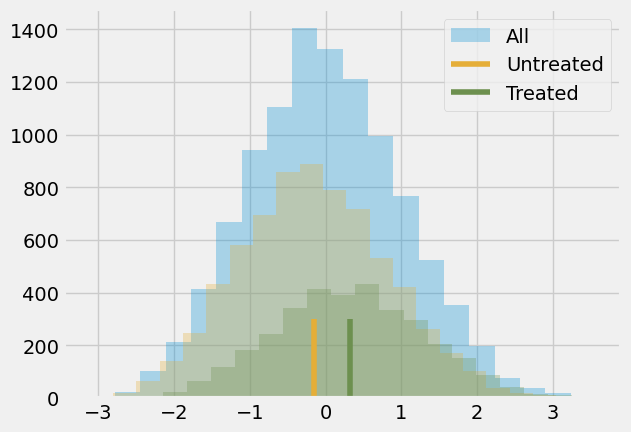

In [20]:
plt.hist(data["achievement_score"], bins=20, alpha=0.3, label="All")
plt.hist(data.query("intervention==0")["achievement_score"], bins=20, alpha=0.3, color="C2")
plt.hist(data.query("intervention==1")["achievement_score"], bins=20, alpha=0.3, color="C3")
plt.vlines(-0.1538, 0, 300, label="Untreated", color="C2")
plt.vlines(-0.1538+0.4723, 0, 300, label="Treated", color="C3")
plt.legend();

In [21]:
## convert the categorical features in the dataset to dummies
categ = ["ethnicity", "gender", "school_urbanicity"]
cont = ["school_mindset", "school_achievement", "school_ethnic_minority", "school_poverty", "school_size"]

data_with_categ = pd.concat([
    data.drop(columns=categ), # dataset without the categorical features
    pd.get_dummies(data[categ], columns=categ, drop_first=False)# categorical features converted to dummies
], axis=1)

print(data_with_categ.shape)

(10391, 32)


In [27]:
## Estimate the propensity score using Logistic Regression.
T = 'intervention'
Y = 'achievement_score'
X = data_with_categ.columns.drop(['schoolid', T, Y])

ps_model = LogisticRegression(C=1e6).fit(data_with_categ[X], data_with_categ[T])

data_ps = data.assign(propensity_score = ps_model.predict_proba(data_with_categ[X])[:, 1])

data_ps[["intervention", "achievement_score", "propensity_score"]].head(10)

,intervention,achievement_score,propensity_score
0,1,0.277359,0.315489
1,1,-0.449646,0.263798
2,1,0.769703,0.344024
3,1,-0.121763,0.344024
4,1,1.526147,0.367789
5,1,0.009607,0.344024
6,1,1.743033,0.367789
7,1,0.953294,0.367789
8,1,2.367780,0.338334
9,1,1.264409,0.338300


__Step 1: Use propensity score to make sure that the propensity score weight indeed reconstructs a population where everyone is treated__.  
- By producing weights $1/e(x)$, it creates the population where everyone is treated
- By providing the weights $1/(1-e(x))$ it creates the population where everyone is untreated.

In [33]:
weight_t = 1/data_ps.query("intervention==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("intervention==0")["propensity_score"])
print("Original Sample Size", data.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 10391
Treated Population Sample Size 10388.575092093015
Untreated Population Sample Size 10391.438139669131


__Step 2: Use propensity score to find evidence of confounding__. 
- If a segmentation of the population has a higher propensity score than another, it means that __something which is not random is causing the treatment__. 
- If that same thing is also causing the outcome, we have confounding. 
- In our case, we can see that students that reported to be more ambitious also have a higher probability of attending the growth mindset seminar.

Text(0.5, 1.0, 'Confounding Evidence')

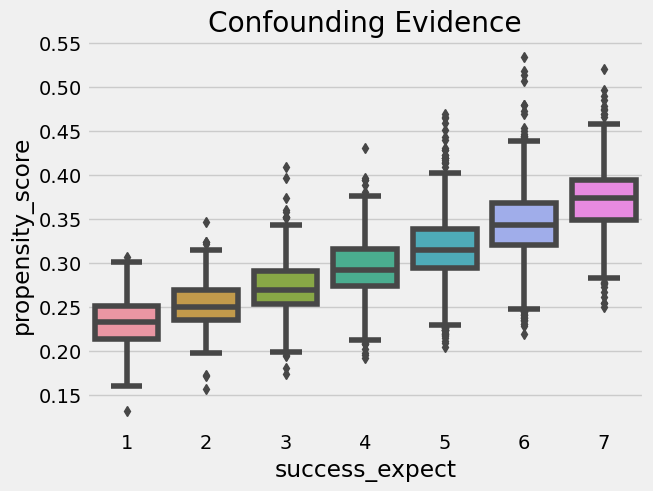

In [31]:
sns.boxplot(x="success_expect", y="propensity_score", data=data_ps)
plt.title("Confounding Evidence")

__Step 3: Use propensity score to check there is overlap between the treated and untreated population.__
- To do so, we can see the empirical distribution of the propensity score on the untreated and on the treated. 
- Looking at the image below, we can see that no one has a propensity score of zero and that even in lower regions of the propensity score we can find both treated and untreated individuals. 
- This is what we call a nicely __balanced__ treated and untreated population. 

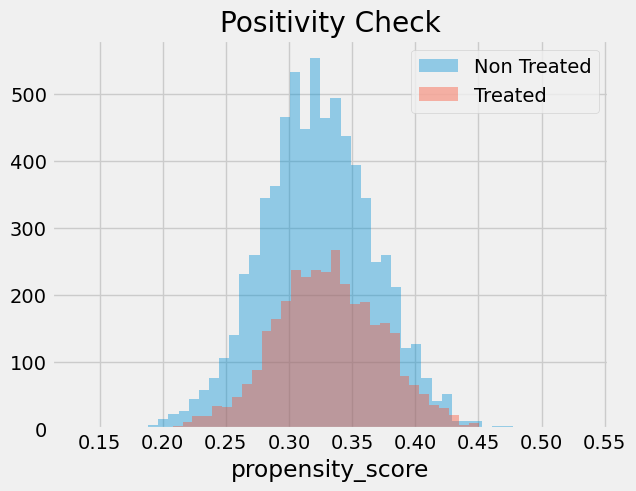

In [32]:
sns.distplot(data_ps.query("intervention==0")["propensity_score"], kde=False, label="Non Treated")
sns.distplot(data_ps.query("intervention==1")["propensity_score"], kde=False, label="Treated")
plt.title("Positivity Check")
plt.legend();

__Step 4: Finally, we can use our propensity score weighting estimator to estimate the ATE average treatment effect.__
- propensity score weighting estimator:

$
E\bigg[Y \dfrac{T-e(x)}{e(x)(1-e(x))}\bigg]
$


In [34]:
weight = ((data_ps["intervention"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("intervention==1")["achievement_score"]*weight_t) / len(data)
y0 = sum(data_ps.query("intervention==0")["achievement_score"]*weight_nt) / len(data)

ate = np.mean(weight * data_ps["achievement_score"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.25958063246387597
Y0: -0.1289225549136946
ATE 0.3885031873775723


__Step 5: Account for Errors in the Estimation process__
- Since we estimate $P(x)$ with $\hat{P}(x)$, we need to account for the __errors__ in this estimation process.
- This can be done by __bootstrapping__ the whole procedure, i.e. __sampling with replacement__ from the original data and computing the ATE. Then repeat this many times to get the __distribution of the ATE estimate__.

In [40]:
print(data_with_categ.shape)
data_sample = data_with_categ.sample(frac = 1, replace = True) # a random 100% sample is drawn
print(data_sample.shape)
print(data_sample.head())

(10391, 32)
(10391, 32)
      schoolid  intervention  achievement_score  ...  school_urbanicity_2  \
1755        39             1           1.660001  ...                    1   
1177        58             1           0.542002  ...                    0   
921         62             1           0.492635  ...                    0   
5943        57             0          -0.253094  ...                    1   
4465        67             0          -0.318222  ...                    0   

      school_urbanicity_3  school_urbanicity_4  
1755                    0                    0  
1177                    0                    0  
921                     0                    1  
5943                    0                    0  
4465                    0                    1  

[5 rows x 32 columns]


In [ ]:
# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000
ates = Parallel(n_jobs=4)(delayed(run_ps)(data_with_categ.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)